# Merged notebook containing code and learnings from cxr project
This notebook is meant as a starting point for the master thesis neural net. Ideas, learnings and code from previous notebooks is gathered and described, to summarize the current status of the project.

## General components that can be kept
*1. Preamble*<br>
Imort of packages<br>
Configuration variables like file paths, boolean switches, numeric settings, etc.

*2. Getting the data*<br>
Funciton definitions<br>
*CHANGES NECESSARY* Read meta data + image files and convert it to a dataframe<br>
*CHANGES NECESSARY* Unify labling of datasets<br>
Train / Test / Val split<br>
Shuffling data

*3. Data preprocessing*<br>
Image augmentation<br>
Data generator class<br>

*4. Model training*<br>
**TODO: Think about a concept for comparing the nets**<br>
Define neural net architecture<br>
Model settings like learning rate reduction, early stopping, model save setting<br>
Training the model

*5. Model evaluation*<br>
Check performance parameters like:
- accuracy
- loss
- recall
- f1

Evaluate generalizability on validation data<br>
Show confusion matrix

# 1. Preamble

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [2]:
import pandas as pd
import math
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from pathlib import Path
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import activations
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, Callback, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, AveragePooling2D, Conv2D, MaxPool2D, Activation, GlobalAveragePooling2D, Lambda
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split

In [3]:
# Config
IMG_SIZE = 256
BATCH_SIZE=32
CHANNELS=1
USE_MASKS=False

MODELSAVE = "models/test_saving_model"

if(USE_MASKS):
    MODELSAVE += "_w_masks.h5"
else:
    MODELSAVE += "_wo_masks.h5"

pd.set_option('display.max_colwidth', None)

DATASET_SOURCE = 1
USE_AWS = False
if USE_AWS:
    DATSET_SOURCE = 2
    
base_path = ''

if DATASET_SOURCE == 0:      # local
    base_path = '/mnt/f/DatasetsChestXRay/'
elif DATASET_SOURCE == 1:    # oth amberg
    base_path = '/home/9424/NAVARA/masterarbeit/datasets/'
elif DATASET_SOURCE == 2:    # aws
    base_path = ''

datasets = {
    'padchest': 'BIMCV-PadChest/',
    'cxr14': 'ChestX-ray14_NationalInstituesofHealthClinicalCenter/',
    'chexpert': 'CheXpert/',
    'kermany': 'KermanyChildStudy/',
    'mimic': 'MIMIC-CXR/',
    'openi': 'Open-i_IndianaUniversityNetworkforPatientCare/'
}

## Dataset parent class
A class that is suitable for creating a combined dataset consisting of different original datasets

In [4]:
class dataset:
    def __init__(self):
        self.df = None
        self.train = None
        self.test = None

    def train_test_split(self, test_size=0.2, random_state=200):
        self.train, self.test = train_test_split(self.df, test_size=test_size, random_state=random_state)

    def shuffle(self, random_state=200):
        self.df = self.df.sample(frac=1, random_state=random_state).reset_index(drop=True)
        self.train = self.train.sample(frac=1, random_state=random_state).reset_index(drop=True)
        self.test = self.test.sample(frac=1, random_state=random_state).reset_index(drop=True)
        

## Dataset child class
A class that is used to retrieve data from the original datasets

In [5]:
class original_dataset(dataset):
    def __init__(self, name, folder):
        super().__init__()
        self.name = name
        self.folder = folder
        self.path = base_path + self.folder
        self.df = self.create_dataset()

    def create_dataset(self):
        # initialize dataframe
        data = {}
        i = 0
        # iterate over folders and files
        for label_folder in ['normal/', 'pneumonia/']:
            for filename in os.listdir(self.path + label_folder):
                img_path = self.path + label_folder + str(filename)
                label_pneumonia = 0
                if label_folder == 'pneumonia/':
                    label_pneumonia = 1
                data[i] = {'img': img_path, 'dataset': self.name, 'label_pneumonia': label_pneumonia, 'label_viral': None, 'label_covid': None}
                i = i + 1

        print("Successfully created " + self.name + " dataset")
        return pd.DataFrame.from_dict(data, "index")


# 2. Load Data

In [6]:
# dictionary of all datasets
dataset_dict = {}

# load all datasets and execute a train test split
for dataset_name, folder_name in datasets.items():
    tmp_dataset = original_dataset(dataset_name, folder_name)
    tmp_dataset.train_test_split()
    tmp_dataset.shuffle()
    dataset_dict[dataset_name] = tmp_dataset



Successfully created padchest dataset
Successfully created cxr14 dataset
Successfully created chexpert dataset
Successfully created kermany dataset
Successfully created mimic dataset
Successfully created openi dataset


In [7]:
dataset_dict['kermany'].df.head()

,img,dataset,label_pneumonia,label_viral,label_covid
0,/home/9424/NAVARA/masterarbeit/datasets/KermanyChildStudy/pneumonia/person492_bacteria_2085.jpeg,kermany,1,None,None
1,/home/9424/NAVARA/masterarbeit/datasets/KermanyChildStudy/pneumonia/person779_bacteria_2683.jpeg,kermany,1,None,None
2,/home/9424/NAVARA/masterarbeit/datasets/KermanyChildStudy/pneumonia/person1589_virus_2763.jpeg,kermany,1,None,None
3,/home/9424/NAVARA/masterarbeit/datasets/KermanyChildStudy/pneumonia/person1580_virus_2739.jpeg,kermany,1,None,None
4,/home/9424/NAVARA/masterarbeit/datasets/KermanyChildStudy/normal/NORMAL2-IM-1371-0001.jpeg,kermany,0,None,None


In [8]:
dataset_dict['kermany'].test.head()

,img,dataset,label_pneumonia,label_viral,label_covid
0,/home/9424/NAVARA/masterarbeit/datasets/KermanyChildStudy/pneumonia/person1449_virus_2476.jpeg,kermany,1,None,None
1,/home/9424/NAVARA/masterarbeit/datasets/KermanyChildStudy/pneumonia/person978_virus_1653.jpeg,kermany,1,None,None
2,/home/9424/NAVARA/masterarbeit/datasets/KermanyChildStudy/pneumonia/person1608_virus_2786.jpeg,kermany,1,None,None
3,/home/9424/NAVARA/masterarbeit/datasets/KermanyChildStudy/pneumonia/person494_bacteria_2090.jpeg,kermany,1,None,None
4,/home/9424/NAVARA/masterarbeit/datasets/KermanyChildStudy/pneumonia/person1087_bacteria_3027.jpeg,kermany,1,None,None


# 3. Data Preprocessing

## Image Augmentation

In [9]:
import imgaug.augmenters as iaa
aug = iaa.AllChannelsCLAHE(clip_limit=(0.05))

In [10]:
def applySigmoidContrast(img):
    img = aug.augment_image(img)
    return img

In [11]:
import imgaug as ia
import imgaug.augmenters as iaa

sometimes = lambda aug: iaa.Sometimes(0.5, aug)
sometimes25 = lambda aug: iaa.Sometimes(0.25, aug)

seq_img = iaa.Sequential([
    # sometimes(iaa.SigmoidContrast(gain=(3, 10), cutoff=(0.4, 0.6))),
    sometimes(iaa.Affine(
            rotate=(-10, 10),
            shear=(-10,10),
            scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
            translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}
    )),
    sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.15))),
], random_order=True)

## Data Generator class

In [12]:
class DataGenerator(tf.keras.utils.Sequence):

    def __init__(self, df, augment, img_size, batch_size=8, shuffle=True, useMasks=True):
        self.batch_size = batch_size
        self.df = df
        self.indices = self.df.index.tolist()
        self.shuffle = shuffle
        self.augment = augment
        self.img_size = img_size
        self.useMasks = useMasks

    def __len__(self):
        return math.ceil(len(self.indices)/ self.batch_size)

    def __getitem__(self, index):
        indexes = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch = [self.indices[k] for k in indexes]
        X, y = self.__get_data(batch)
        return np.array(X), np.array(y)

    def on_epoch_end(self):
        if self.shuffle == True:
            np.random.shuffle(self.indices)

    def __get_data(self, batch):
        X_img_paths = self.df['img']
        # X_mask_paths = self.df['mask']
        X_imgs = []
        # X_masks = []
        Y = self.df['label_pneumonia'].iloc[batch].to_numpy()

        for i in range(0, len(batch)):
            img = cv2.resize(cv2.imread(str(X_img_paths.iloc[batch[i]]), cv2.IMREAD_GRAYSCALE), (self.img_size, self.img_size))
            img = img.reshape(img.shape[0], img.shape[1],1)

            if not self.useMasks:
                if(self.augment is True):
                    seq_img_i = seq_img.to_deterministic()   
                    img = seq_img_i.augment_image(img)
                # else img remains untouched
            else:
                mask = cv2.imread(str(X_mask_paths.iloc[batch[i]]), cv2.IMREAD_GRAYSCALE)
                #mask = cv2.resize(mask, (self.img_size, self.img_size))
                mask = cv2.threshold(mask,0,1,cv2.THRESH_BINARY)[1]
                # Multiply binarized mask on grayscaled version of the x-ray. 
                # So only the lung will remain, everything else will be set to 0
                try:
                    mask = mask.reshape(IMG_SIZE,IMG_SIZE,1)
                except:
                    print("i", i)
                    print(str(X_mask_paths.iloc[batch[i]]))
                cutout_img = img * mask
                cutout_img = cutout_img.reshape(IMG_SIZE,IMG_SIZE,1)

                if(self.augment is True):
                    seq_img_i = seq_img.to_deterministic()   
                    img = seq_img_i.augment_image(img) #### img
                    cutout_img = seq_img_i.augment_image(cutout_img) #### cutout

                img = np.dstack([img, cutout_img])
                mask = mask / 255.0

            # normalize
            img = img / 255.0

            X_imgs.append(img)

        return X_imgs, Y

# 4. Model Training

In [13]:
def getModel():
    model = Sequential()
    # Conv block1 = cb0
    model.add(Conv2D(3, (1,1), padding="same",activation="relu", input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS)))
    model.add(Conv2D(32, (3,3), padding = "same", activation='relu', input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS), name="cb0_conv0"))
    model.add(Conv2D(32, (3,3), padding = "same", activation='relu', name="cb0_conv1"))
    model.add(MaxPool2D(pool_size = (3, 3), name="cb0_maxpool"))
    model.add(Dropout(0.2, name="cb0_dropout"))

    # Conv block2 = cb1
    model.add(Conv2D(64, (3,3), padding = "same", activation='relu', name="cb1_conv0"))
    model.add(Conv2D(64, (5,5), strides=(2,2), padding = "same", activation='relu', name="cb1_conv1"))
    model.add(Conv2D(64, (3,3), padding = "same", activation='relu', name="cb1_conv2"))
    model.add(MaxPool2D(pool_size = (2, 2), name="cb1_maxpool"))
    model.add(Dropout(0.2, name="cb1_dropout"))

    # Dense block = db
    model.add(Flatten())
#     model.add(Dense(1024, activation='relu', name="db_dense1024"))
#     model.add(Dense(512, activation='relu', name="db_dense512"))
#     model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu', name="db_dense256"))
#     model.add(Dropout(0.2))

    model.add(Dense(1, activation='sigmoid', name="db_dense1"))

    model.compile(optimizer = Adam(learning_rate=0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

In [14]:
# K-Fold
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import f1_score, accuracy_score

In [15]:
kf5 = StratifiedKFold(n_splits=5, random_state=200, shuffle=True)

In [16]:
learning_rate_reduction = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.8,
    patience=3,
    verbose=2, # verbose=1 results in a warning, use verbose=2 (bit less info) or verbose=0 (no info) instead
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0,
)

mcp_save = ModelCheckpoint(MODELSAVE, save_best_only=True, monitor='val_loss', mode='min')

In [17]:
%%time

run = 1
val_scores = []
f1_scores = []
histories = []
best_f1_model = None
highestF1 = 0
EPOCHS = 1 # 12

df_train = dataset_dict['kermany'].train.head(200)

for train_index, val_index in kf5.split(df_train, df_train.label_pneumonia):
    print("Fold Nr.: ", run)
    df_fold_train = df_train.iloc[train_index]
    df_fold_val = df_train.iloc[val_index]

    df_fold_train.reset_index(drop=True, inplace=True)
    df_fold_val.reset_index(drop=True, inplace=True)
    
    
    # print('=== Train Data: ===')
    # print('Normal:', len(df_fold_train[df_fold_train['label'] == 0]))
    # print('Pneumonia:', len(df_fold_train[df_fold_train['label'] == 1]))
    # print('|---> Bacterial:', len(df_fold_train[df_fold_train['label2'] == 'bacteria']))
    # print('|---> Viral:', len(df_fold_train[df_fold_train['label2'] == 'virus']))
    # print('    |---> Covid:', len(df_fold_train[df_fold_train['label3'] == 'covid19']))
    
    # print('=== Val Data: ===')
    # print('Normal:', len(df_fold_val[df_fold_val['label'] == 0]))
    # print('Pneumonia:', len(df_fold_val[df_fold_val['label'] == 1]))
    # print('|---> Bacterial:', len(df_fold_val[df_fold_val['label2'] == 'bacteria']))
    # print('|---> Viral:', len(df_fold_val[df_fold_val['label2'] == 'virus']))
    # print('    |---> Covid:', len(df_fold_val[df_fold_val['label3'] == 'covid19']))
    
    train_generator = DataGenerator(df_fold_train, True, IMG_SIZE, batch_size=BATCH_SIZE, shuffle=False, useMasks=USE_MASKS)
    val_generator = DataGenerator(df_fold_val, False, IMG_SIZE, batch_size=BATCH_SIZE, shuffle=False, useMasks=USE_MASKS)
    

    # Adjust class_weights since we're dealing with imbalanced data here
    class_weights = class_weight.compute_class_weight('balanced', np.unique(df_fold_train['label_pneumonia']), df_fold_train['label_pneumonia'])
    class_weights = {0: class_weights[0], 1: class_weights[1]}
    print("Class weights: ", class_weights)

    model = getModel()
    history = model.fit(train_generator,
                    validation_data=val_generator,
                    validation_steps=len(val_generator),
                    steps_per_epoch=len(train_generator),
                    epochs=EPOCHS,
                    class_weight=class_weights,
                    callbacks=[mcp_save, learning_rate_reduction], #mcp_save, learning_rate_reduction]],
                    verbose = True)

    predictions = model.predict(val_generator)
    y_pred = (predictions > 0.5).astype('uint8')

    histories.append(history)

    f1 = f1_score(y_pred, df_fold_val.label_pneumonia)

    if(highestF1 == 0):
        highestF1 = f1
        best_f1_model = model
    else:
        if(f1 > highestF1):
            highestF1 = f1
            best_f1_model = model

    val_acc = accuracy_score(y_pred , df_fold_val.label_pneumonia)

    f1_scores.append(f1)
    val_scores.append(val_acc)
    
    run += 1

Fold Nr.:  1
Class weights:  {0: 2.5, 1: 0.625}


/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[0 1], y=0      1
1      1
2      1
3      1
4      1
      ..
155    1
156    1
157    1
158    1
159    1
Name: label_pneumonia, Length: 160, dtype: int64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


5/5 [==============================] - 3s 683ms/step - loss: 0.7104 - accuracy: 0.6250 - val_loss: 0.7233 - val_accuracy: 0.1750
Fold Nr.:  2
Class weights:  {0: 2.5806451612903225, 1: 0.6201550387596899}
5/5 [==============================] - 3s 693ms/step - loss: 0.6978 - accuracy: 0.6562 - val_loss: 0.6918 - val_accuracy: 0.7000
Fold Nr.:  3
Class weights:  {0: 2.5806451612903225, 1: 0.6201550387596899}
5/5 [==============================] - 3s 516ms/step - loss: 0.6974 - accuracy: 0.2937 - val_loss: 0.7025 - val_accuracy: 0.2000
Fold Nr.:  4
Class weights:  {0: 2.5806451612903225, 1: 0.6201550387596899}
5/5 [==============================] - 3s 538ms/step - loss: 0.7132 - accuracy: 0.3688 - val_loss: 0.7189 - val_accuracy: 0.2000
Fold Nr.:  5
Class weights:  {0: 2.5806451612903225, 1: 0.6201550387596899}
5/5 [==============================] - 3s 556ms/step - loss: 0.6933 - accuracy: 0.5813 - val_loss: 0.6923 - val_accuracy: 0.8000
CPU times: user 17.8 s, sys: 1.08 s, total: 18.8 s


In [18]:
np.array(f1_scores).mean()

0.33906810035842294

In [19]:
np.array(val_scores).mean()

0.41500000000000004

In [20]:
# set model to the best f1 model
model = best_f1_model

# 5. Model Evaluation

In [21]:
df_test = dataset_dict['kermany'].test.head(40)

In [22]:
test_generator = DataGenerator(df_test, False, IMG_SIZE, batch_size=32, shuffle=False, useMasks=USE_MASKS)

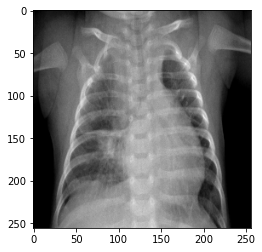

In [23]:
plt.imshow(test_generator.__getitem__(0)[0][0][:,:,0], cmap="gray")

In [24]:
model.evaluate(test_generator)

2/2 [==============================] - 0s 61ms/step - loss: 0.6923 - accuracy: 0.8000


[0.6922925114631653, 0.800000011920929]

In [25]:
print("Test pneumonia cases: ", len(df_test[df_test['label_pneumonia'] == 1]))
print("Test normal cases: ", len(df_test[df_test['label_pneumonia'] == 0]))

Test pneumonia cases:  32
Test normal cases:  8


In [26]:
predictions = model.predict(test_generator)

In [27]:

y_true = test_generator.df.label_pneumonia # we can do this since we do not shuffle in test_generator ;)
y_pred = predictions > 0.5

In [28]:
y_pred_classes = []

for x in y_pred:
    if x == 0:
        y_pred_classes.append("NORMAL")
    else:
        y_pred_classes.append("PNEUMONIA")

In [29]:
y_true_classes = []

for x in y_true:
    if x == 0:
        y_true_classes.append("NORMAL")
    else:
        y_true_classes.append("PNEUMONIA")

In [30]:
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[ 0  8]
 [ 0 32]]


In [31]:
report = classification_report(y_true_classes, y_pred_classes) #, target_names=["NORMAL", "PNEUMONIA"])
print(report)

              precision    recall  f1-score   support

      NORMAL       0.00      0.00      0.00         8
   PNEUMONIA       0.80      1.00      0.89        32

    accuracy                           0.80        40
   macro avg       0.40      0.50      0.44        40
weighted avg       0.64      0.80      0.71        40



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Text(0, 0.5, 'Normal'), Text(0, 1.5, 'Pneumonia')]

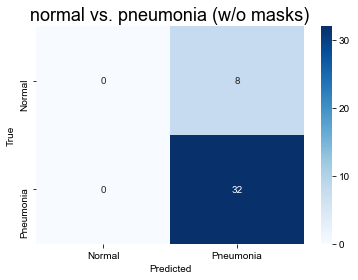

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Blues') #annot=True to annotate cells
sns.set(font_scale=1.5)

# labels, title and ticks
ax.set_xlabel('Predicted')
ax.set_ylabel('True') 
ax.set_title('normal vs. pneumonia (w/o masks)')
ax.xaxis.set_ticklabels(['Normal', 'Pneumonia'])
ax.yaxis.set_ticklabels(['Normal', 'Pneumonia'])